# Problem statement

- we are given with source and destination nodes as a raw data and asked to predict the higher possibility of forming a link between non connected source and destination nodes based on the given connected nodes data.
- So that we can recommend a non connected nodes to form a connection with nodes which have higher probability of forming a connection together.

In [7]:
from google.colab import drive   #mounting google drive
drive.mount('/content/drive')

Mounted at /content/drive


**Please read how EDA on data and preprocess of the data done on in the respective ipython notebook**

In [11]:
! unzip drive/My\ Drive/FB_assignment/Facebook-20221031T130316Z-001  #unzipping files

Archive:  drive/My Drive/FB_assignment/Facebook-20221031T130316Z-001.zip
  inflating: Facebook/FB_featurization.ipynb  
  inflating: Facebook/FB_EDA.ipynb   
  inflating: Facebook/FB_Models.ipynb  
  inflating: Facebook/data/test_y.csv  
  inflating: Facebook/data/after_eda/test_pos_after_eda.csv  
  inflating: Facebook/data/fea_sample/page_rank.p  
  inflating: Facebook/data/fea_sample/storage_sample_stage2.h5  
  inflating: Facebook/data/after_eda/test_neg_after_eda.csv  
  inflating: Facebook/data/fea_sample/hits.p  
  inflating: Facebook/data/fea_sample/storage_sample_stage3.h5  
  inflating: Facebook/data/after_eda/test_after_eda.csv  
  inflating: Facebook/data/train_y.csv  
  inflating: Facebook/data/fea_sample/katz.p  
  inflating: Facebook/data/fea_sample/storage_sample_stage4.h5  
  inflating: Facebook/data/after_eda/train_neg_after_eda.csv  
  inflating: Facebook/data/train.csv  
  inflating: Facebook/data/after_eda/train_woheader.csv  
  inflating: Facebook/data/after_eda/t

In [71]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix

In [14]:
%pwd

'/content'

In [17]:
!cd "/content/Facebook"

In [20]:
#!cp -r "/content/Facebook" "/content/drive/My Drive/FB_assignment"

In [15]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):  #reading data from stored file
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

DiGraph with 1780722 nodes and 7550015 edges


### SVD_dot feature

In [90]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [91]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()   #creating adjacency matrix...so that we can decompose it to get vector for each edge connection

In [92]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)             #using U and V we can extract features with each of 6 dimentions for each edge connection

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [93]:
def svd_dot(x,y,S):
    try:
        x_index = sadj_dict[x]   #x-value of the dictionary......    x_index--index stored respective to that value
        vec_x= S[x_index]             #U[x_index]-----retuens the 6 dim feature respecttive to the index
        y_index = sadj_dict[y]
        vec_y= S[y_index]
        
        dot_prod=np.dot(vec_x,vec_y)  #calculating dot product between vectors of x and y
        return dot_prod
    except:
        return 0   

In [94]:
#reading hdf files
from pandas import read_hdf
df_final_train = read_hdf('Facebook/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('Facebook/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [95]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [96]:
#calculating source and destination node's vector's dot product
df_final_train['SVD_dot'] = df_final_train.apply(lambda row: svd_dot(row['source_node'],row['destination_node'],U),axis=1)
df_final_test['SVD_dot'] = df_final_test.apply(lambda row: svd_dot(row['source_node'],row['destination_node'],U),axis=1)


In [97]:
#this function is to calculate number of paths exist inbetween two nodes 
#but since the graph seems too large,it takes too much time to calculate even for a single node...so this code is commented out.

'''def number_of_paths(x,y,G): 
    ls=[]                                     #https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.simple_paths.all_simple_paths.html#networkx.algorithms.simple_paths.all_simple_paths
    for path in nx.all_simple_paths(G, source=x, target=y):
        ls.append(path)
    return len(ls)'''

'def number_of_paths(x,y,G): \n    ls=[]                                     #https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.simple_paths.all_simple_paths.html#networkx.algorithms.simple_paths.all_simple_paths\n    for path in nx.all_simple_paths(G, source=x, target=y):\n        ls.append(path)\n    return len(ls)'

In [49]:
#_final_train['number_of_paths'] = df_final_train.apply(lambda row: number_of_paths(row['source_node'],row['destination_node'],train_graph),axis=1)

### Preferential_attachment feature

In [98]:
#function to calulate preferential attachment
#it is calculated by the multiplication between the number of friends (|Γ(x)|) or followers each vertex has.    reference taken from.... #http://be.amazd.com/link-prediction/
def calc_preferential_attachment(a,b):
    
    try:
        return (len(list(train_graph.predecessors(a))))*(len(list(train_graph.predecessors(b))))  #multiplication of number of neighbour(followers) of source and destination node
    except:
        return 0

In [99]:
df_final_train['preferential_attachment'] = df_final_train.apply(lambda row: calc_preferential_attachment(row['source_node'],row['destination_node']),axis=1)
df_final_test['preferential_attachment'] = df_final_test.apply(lambda row: calc_preferential_attachment(row['source_node'],row['destination_node']),axis=1)

In [102]:
y_train = df_final_train.indicator_link  #getting y_labels
y_test = df_final_test.indicator_link

In [103]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)   #drop the 3 columns
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)  

# Hyperparameter tuning

In [105]:


param_dist = {"n_estimators":sp_randint(105,125),       #parameter list
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

model = XGBClassifier(random_state=25,n_jobs=-1)       #xgboost classifier

clf = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)
clf.fit(df_final_train, y_train)    #fitting the  model with train data

results = pd.DataFrame.from_dict(clf.cv_results_)   #storing Gridsearch results



train_auc= results['mean_train_score']       #storing required Gridsearch results in required variable
cv_auc = results['mean_test_score'] 


results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,81.726707,1.597975,0.067168,0.002350,14,51,125,117,"{'max_depth': 14, 'min_samples_leaf': 51, 'min...",0.980290,...,0.999700,0.999689,0.999767,0.999956,0.999944,0.999789,0.999911,0.999967,0.999843,0.000110
1,66.952500,1.025313,0.057987,0.001542,12,33,138,109,"{'max_depth': 12, 'min_samples_leaf': 33, 'min...",0.980684,...,0.997352,0.997430,0.997698,0.997218,0.997040,0.997095,0.997720,0.997519,0.997332,0.000256
2,61.323466,2.076874,0.056409,0.002824,11,56,179,106,"{'max_depth': 11, 'min_samples_leaf': 56, 'min...",0.980593,...,0.994707,0.994740,0.994404,0.994293,0.994774,0.995165,0.994897,0.994182,0.994585,0.000336
3,72.023542,1.551954,0.058923,0.001219,13,49,165,108,"{'max_depth': 13, 'min_samples_leaf': 49, 'min...",0.980589,...,0.998433,0.998577,0.998989,0.998677,0.998644,0.998399,0.998800,0.998600,0.998625,0.000173
4,87.868321,1.228773,0.069272,0.001249,14,28,111,121,"{'max_depth': 14, 'min_samples_leaf': 28, 'min...",0.980388,...,0.999878,0.999811,0.999900,1.000000,0.999956,0.999845,0.999933,1.000000,0.999913,0.000069


In [106]:
print(train_auc) 
print(cv_auc)

0    0.999843
1    0.997332
2    0.994585
3    0.998625
4    0.999913
Name: mean_train_score, dtype: float64
0    0.980419
1    0.980293
2    0.980236
3    0.980388
4    0.980481
Name: mean_test_score, dtype: float64


In [108]:
print(clf.best_estimator_)  #getting the best estimator

XGBClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
              n_estimators=121, n_jobs=-1, random_state=25)


# Fitting the data with best hyperparameter

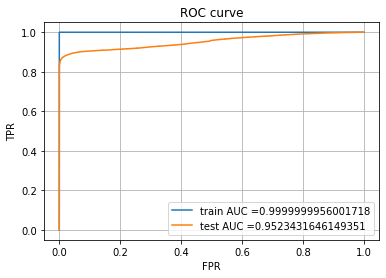

In [109]:


model=XGBClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,   #best model
              n_estimators=121, n_jobs=-1, random_state=25)

model.fit(df_final_train, y_train) 
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class,not the predicted outputs

y_train_pred_proba = model.predict_proba(df_final_train)    
y_test_pred_proba = model.predict_proba(df_final_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_proba[:,[1]])        #find FPR and TPR for plotting roc curve
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_proba[:,[1]])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))   #finding area under the ROC curve using FPR and TPR
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

In [110]:
#f1 score

from sklearn.metrics import f1_score
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9998001598721024
Test f1 score 0.9266542087828081


### plotting confustion matrix

In [111]:


from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


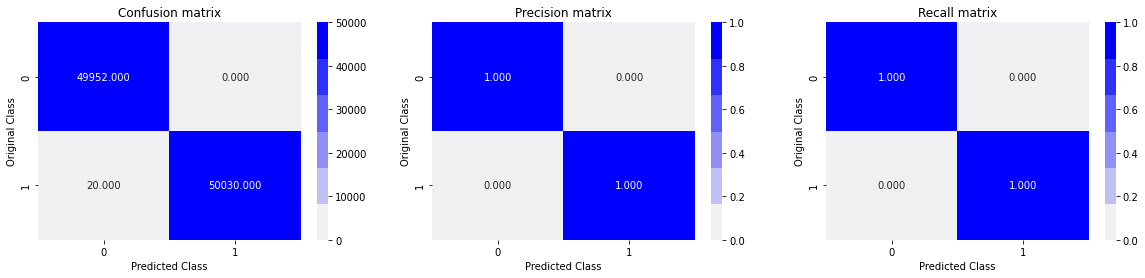

Test confusion_matrix


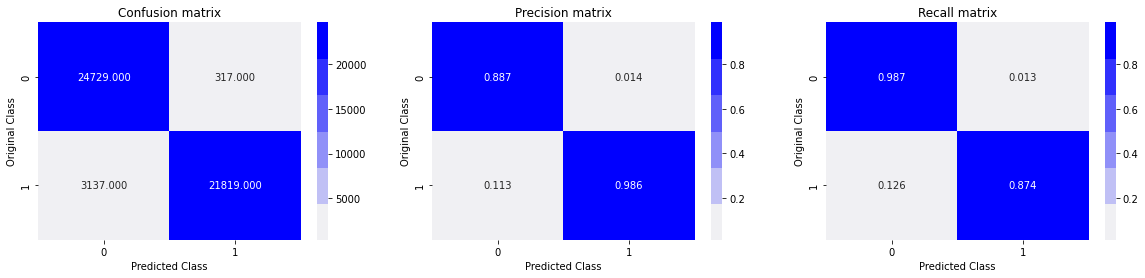

In [112]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

## plotting roc curve for test data

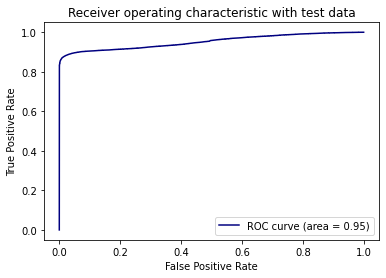

In [113]:

from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test, y_test_pred_proba[:,[1]]) # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class,not the predicted outputs
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

### Getting the top 25 important features and plotting them

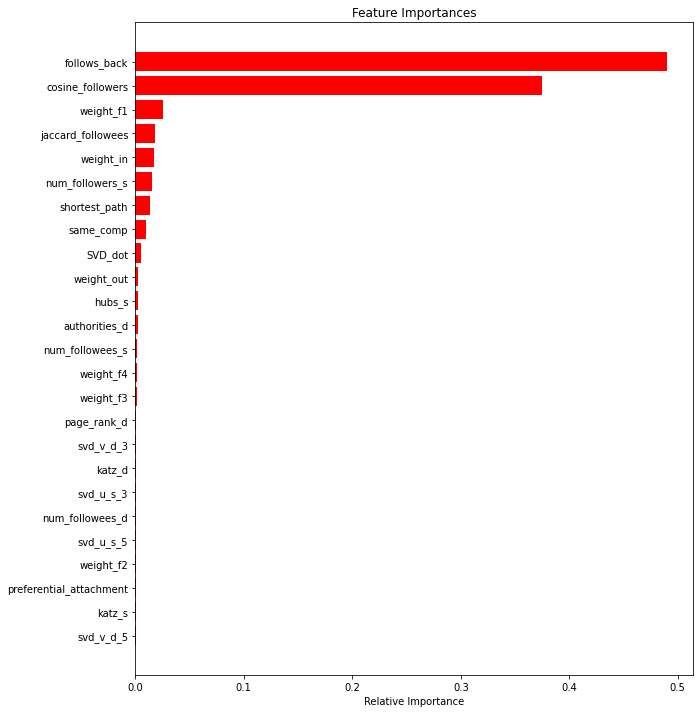

In [114]:


features = df_final_train.columns
importances = model.feature_importances_
indices = (np.argsort(importances))[-25:]      #index of max value features
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')   #draw a bar
plt.yticks(range(len(indices)), [features[i] for i in indices]) #give a name to that bar...... #features[i]--feature name of given index feature
plt.xlabel('Relative Importance')
plt.show()

- we can observe that newly added SVD_dot feature have significant feature important score

# Pretty table

In [9]:
from prettytable import PrettyTable              # Reference Link for Pretty table:  https://pypi.org/project/prettytable/
x = PrettyTable()
x.field_names = ["Model", "hyperparamerter", "train f1 score","test f1 score","train_AUC","test_AUC"]
x.add_row(["Xgboost", "MSL=28,MD=14,N=121 and MSS=111",0.99980,0.92665,0.9999,0.9523])
print(x)

+---------+--------------------------------+----------------+---------------+-----------+----------+
|  Model  |        hyperparamerter         | train f1 score | test f1 score | train_AUC | test_AUC |
+---------+--------------------------------+----------------+---------------+-----------+----------+
| Xgboost | MSL=28,MD=14,N=121 and MSS=111 |     0.9998     |    0.92665    |   0.9999  |  0.9523  |
+---------+--------------------------------+----------------+---------------+-----------+----------+


- Here **MSL,MD,N and MSS** represents **min_samples_leaf , max_depth , n_estimators , min_samples_split** respectively

# Procedure we have taken
- we are given with source and destination nodes as a raw data and asked to predict the higher possibility of forming a link between non connected source and destination nodes based on the given connected nodes data


- we first decided to pose it as binary class classfication problem in which given a source and destination node ,if y=1 that means ,they can be suggested to connect to each other and y=0 represent they are not suggested to have connection between them.


- for this take we are  given with already connected nodes only...so we created train and test data for the non connected node pairs also by assuming that which ever node pair is having **shorted path distance more that 2**, we make them as non connected node pairs


- then we created feature using graph based property like **Jaccard similarity,Cosine distance, Page Ranking,Adamic/Adar Index,Katz Centrality** and ect....and part of this assignment we also added  **svd_dot and Preferential Attachment** features also


- then we hyperparameter tuned the xgboost model with **n_estimators,max_depth,min_samples_split,min_samples_leaf** as hyperparamter and did the random search to get best value for all hyper parameter...


- Finally we fitted the best model with the data and arrived with **train auc of 0.9999 and test auc of 0.9523** and we also plotted the feature important score for **top 25 features** in which **follows back and cosine followers**have got top scores and newly added feature **SVD_dot** also contributed significatly to the preformance of our model...

# Observation
- After we fitted the data to the Xgboost model, for **train data we got precision and recall of 1** for both the classes...


- for **class 0 of test data** we got **precision of 88.7% and recall of 98.7%**. It means that 'of all the nodes pairs that are predicted to have no link,88.7% of them are actullay have no link'... and 'of all the node pairs that are actullay do not have links,98.7% are correctly predicted 


- for **class 1 of test data** we got **precision of 98.6% and recall of 87.4%**. It means that 'of all the nodes pairs that are predicted to have link,98.6% of them are actullay have a link'... and 'of all the node pairs that are actullay have links,87.4% are correctly predicted.


- we got **train auc of 0.9999 and test auc of 0.9523**...train auc is very large because tree based model (xgboost ) do overfit...here the both train and test auc is very good.


- we got high feature importance score for **"follows_back"** feature which can be interpreted as if someone follows back his followers then **high value of follows_back means that they are more likely to form new connections with others**.
